

# AUTOENCODER

Fuente: https://github.com/syorami/Autoencoders-Variants






#### Funciones a usar


In [60]:
# de los autoencoder

import warnings
warnings.filterwarnings('ignore')
import os, datetime
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torchvision
# import data_utils
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd import Variable


# de la data_utils
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torchvision import datasets
from torch.utils import data


# funciones

def load_mnist(BATCH_SIZE=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)) #<-- modificado por error en 3 canales, MNIST es de 1 solo canal
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    print(f'Train Data Shape: {trainset.train_data.numpy().shape}')
    print(f'Test Data Shape: {testset.test_data.numpy().shape}')

    return trainloader, testloader


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [61]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### elegir ruta para guardar / cargar el modelo entrenado

In [62]:
# una ruta del drive...
direccion = '/content/drive/MyDrive/Colab_Notebooks/deep_learning/autoencoder'

In [63]:
# esta ruta es el colab mismo.. al cerrar la sesion se pierden los archivos
#direccion = '/content'

### SIMPLE AUTOENCODER

In [64]:
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2),
            ##nn.ReLU(inplace=True)
            ##nn.Tanh()
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 784),
            nn.Tanh()
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def model_training(autoencoder, train_loader, epoch):
    loss_metric = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    autoencoder.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, _ = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder(images)
        loss = loss_metric(outputs, images)
        loss.backward()
        optimizer.step()
        if (i + 1) % LOG_INTERVAL == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], MSE loss:{:.4f}'.format(
                epoch + 1, EPOCHS, i + 1, len(train_loader.dataset) // BATCH_SIZE, loss.item()
            ))


def evaluation(autoencoder, test_loader):
    total_loss = 0
    loss_metric = nn.MSELoss()
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        images, _ = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder(images)
        loss = loss_metric(outputs, images)
        total_loss += loss * len(images)
    avg_loss = total_loss / len(test_loader.dataset)

    print('\nAverage MSE Loss on Test set: {:.4f}'.format(avg_loss))

    global BEST_VAL
    if TRAIN_SCRATCH and avg_loss < BEST_VAL:
        BEST_VAL = avg_loss
        #salvado = os.path.join(path, "User/Desktop", "file.txt")
        torch.save(autoencoder.state_dict(), os.path.join(direccion, "simple_autoencoder_TP_sigmoid.pt"))
        print('Save Best Model in HISTORY\n')

if __name__ == '__main__':

    EPOCHS = 10
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    LOG_INTERVAL = 100
    TRAIN_SCRATCH = True        # whether to train a model from scratch          <-------------- ENTRENAR O USAR YA ENTRENADO
    BEST_VAL = float('inf')     # record the best val loss

    train_loader, test_loader = load_mnist(BATCH_SIZE)

    autoencoder = Autoencoder()
    if cuda: autoencoder.to(device)

    if TRAIN_SCRATCH:
        # Training autoencoder from scratch
        for epoch in range(EPOCHS):
            starttime = datetime.datetime.now()
            model_training(autoencoder, train_loader, epoch)
            endtime = datetime.datetime.now()
            print(f'Train a epoch in {(endtime - starttime).seconds} seconds')
            # evaluate on test set and save best model
            evaluation(autoencoder, test_loader)
        print('Trainig Complete with best validation loss {:.4f}'.format(BEST_VAL))

    else:
        
        ####
        if cuda:
          autoencoder.load_state_dict(torch.load(os.path.join(direccion, "simple_autoencoder_TP_sigmoid.pt")))
        else:
          autoencoder.load_state_dict(torch.load(os.path.join(direccion, "simple_autoencoder_TP_sigmoid.pt"), map_location=torch.device('cpu')))
        ####
        evaluation(autoencoder, test_loader)

        autoencoder.cpu()
        dataiter = iter(train_loader)
        images, _ = next(dataiter)
        images = Variable(images[:32])
        outputs = autoencoder(images.view(images.size(0), -1))

        # plot and save original and reconstruction images for comparisons
        plt.figure(figsize=(16,8))
        plt.subplot(121)
        plt.title('Original MNIST Images')
        imshow(torchvision.utils.make_grid(images))
        plt.subplot(122)
        plt.title('Autoencoder Reconstruction')
        imshow(torchvision.utils.make_grid(
            outputs.view(images.size(0), 1, 28, 28).data
        ))
        plt.savefig(os.path.join(direccion, "simple_autoencoder_TP.png"))

Train Data Shape: (60000, 28, 28)
Test Data Shape: (10000, 28, 28)
Epoch [1/10] - Iter[100/468], MSE loss:0.2738
Epoch [1/10] - Iter[200/468], MSE loss:0.2649
Epoch [1/10] - Iter[300/468], MSE loss:0.2573
Epoch [1/10] - Iter[400/468], MSE loss:0.2392
Train a epoch in 9 seconds

Average MSE Loss on Test set: 0.2403
Save Best Model in HISTORY

Epoch [2/10] - Iter[100/468], MSE loss:0.2329
Epoch [2/10] - Iter[200/468], MSE loss:0.2172
Epoch [2/10] - Iter[300/468], MSE loss:0.2116
Epoch [2/10] - Iter[400/468], MSE loss:0.2170
Train a epoch in 9 seconds

Average MSE Loss on Test set: 0.2132
Save Best Model in HISTORY

Epoch [3/10] - Iter[100/468], MSE loss:0.2211
Epoch [3/10] - Iter[200/468], MSE loss:0.2073
Epoch [3/10] - Iter[300/468], MSE loss:0.2080
Epoch [3/10] - Iter[400/468], MSE loss:0.2058
Train a epoch in 9 seconds

Average MSE Loss on Test set: 0.2068
Save Best Model in HISTORY

Epoch [4/10] - Iter[100/468], MSE loss:0.2006
Epoch [4/10] - Iter[200/468], MSE loss:0.2085
Epoch [4/1

### para lo que continúa (luego del entrenamiento o de cargar el modelo ya guardado) llevamos al modelo a cpu()

In [65]:
autoencoder.to('cpu')

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=2, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)

### Veamos nuestro modelo, parte por parte

In [66]:
autoencoder.encoder

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Sigmoid()
)

In [67]:
autoencoder.decoder

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=128, out_features=784, bias=True)
  (5): Tanh()
)

### Analisis del encoder


#### Copiamos el encondoder y copiamos sus pesos sinápticos.

In [68]:
# estamos generando un nuevo model, que copia el sequential del model original, la parte del encoder
encoder = autoencoder.encoder

In [69]:
encoder.load_state_dict(autoencoder.encoder.state_dict())

<All keys matched successfully>

#### le pasamos un "numero" (imagen) a ver como lo codifica

In [70]:
# sacamos un batch del test_loader
img, label = next(iter(test_loader)) 
# pasamos un indice de dicho batch
indice = 6
img = img[indice]
label = label[indice]
# validamos su tamaño
img.shape

torch.Size([1, 28, 28])

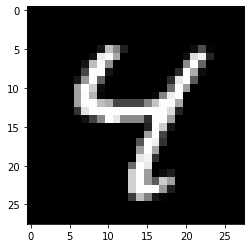

Label: 4


In [71]:
# lo visualizamos
plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(f"Label: {label}")

In [72]:
# para pasarlo a la ENCODER hay que vectorizarlos por que el ENCODER es un MLP
img.view(1, -1).shape

torch.Size([1, 784])

#### pasamos nuestra imagen al ENCODER

In [73]:
num_encoded = encoder(img.view(1, -1))
num_encoded

tensor([[0.7739, 0.4354]], grad_fn=<SigmoidBackward0>)

#### mapeo de la representación del los numeros en el latent space

In [74]:
# mapeo el laten space del test
# le pasamos un batch del TEST set y plotemaos la codificación del mismo
img, label = next(iter(test_loader))

# acá le pasamos TODO el batch del TEST al ENCODER, en las dimensiones adecuadas (las
# imagenes de 28x28 son vectorizadas).

latent = encoder(img.view(img.size(0), -1))
# vemos el tamaño de lo que obtuvimos
print('           batch x size')
latent.shape

           batch x size


torch.Size([128, 2])

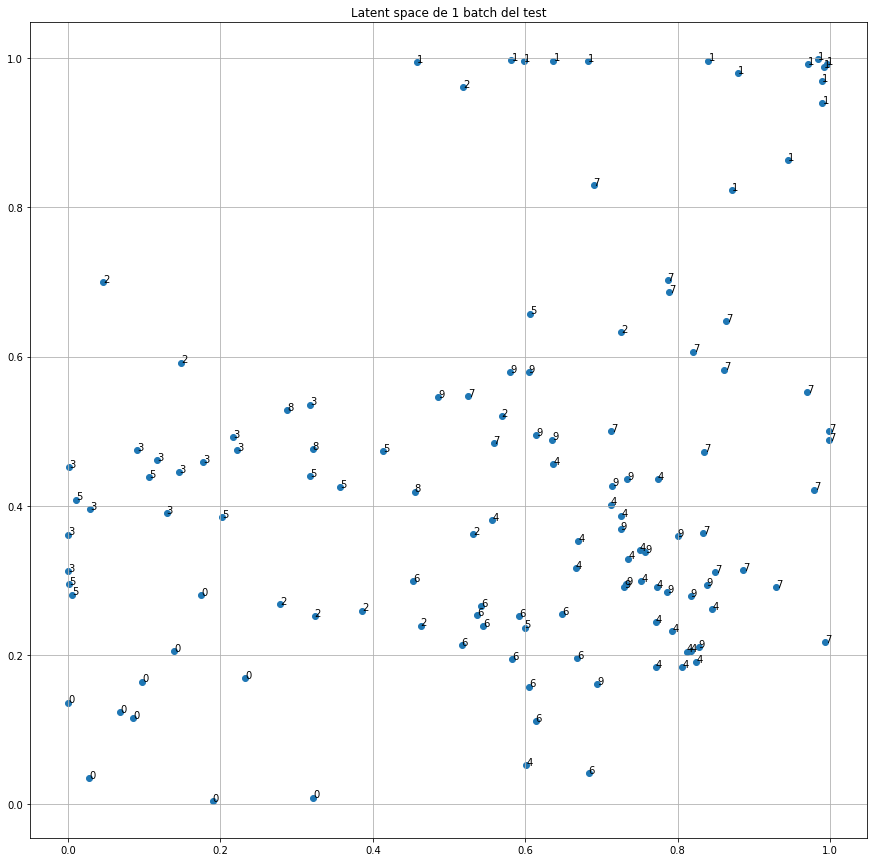

In [75]:
# ploteamos los resultados
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(latent[:,0].data, latent[:,1].data)
# Etiquetamos cada punto para mayor claridad
texts = [ax.text(latent[i,0], latent[i,1], txt.item()) for i, 
      txt in enumerate(label)]

plt.title('Latent space de 1 batch del test')
plt.grid()
plt.show()

### Analisis del decoder

### copiamos el decoder

In [76]:
decoder = autoencoder.decoder

In [77]:
decoder.load_state_dict(autoencoder.decoder.state_dict())

<All keys matched successfully>

#### veamos si le pasamos un rand de [1x2], que ocurre

In [78]:
# generamos el vector de entrada al DECODER
entrada = torch.rand(2)
entrada

tensor([0.9610, 0.5013])

In [79]:
# se lo pasamos al modelo DECODER
est = decoder(entrada)

In [80]:
# vemos le tamaño de la respuesta
est.shape

torch.Size([784])

In [81]:
# lo re-ordenamos y sacamos los valores del tensor (para deshacernos del gradiente)
imagen = est.view(1, 28, 28).data
imagen.shape

torch.Size([1, 28, 28])

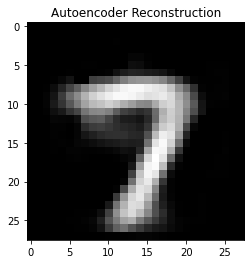

In [82]:
plt.figure()
plt.subplot(111)
plt.title('Autoencoder Reconstruction')
plt.imshow(imagen.squeeze(), cmap="gray")
plt.show()

### Ejercicio

Analizando lo procesado anteriormente y prestando atención a la representación del `latent_space` de batch de TEST ploteado al momento de analizar el encoder, realice un paneo en X e Y del `latent_space` y grafique el resultado que genera el decoder para cada número generado.

Para realizar esto, se deja armada la siguiente celda donde solamente debe fijar los siguientes hiper-parámetros:
- `n` número de imágenes (digits del NMIST) a representar.
- `x_min` valor mínimo de la variable x del `latent_space`.
- `x_max` valor mínimo de la variable x del `latent_space`.
- `y_min` valor mínimo de la variable x del `latent_space`.
- `y_max` valor mínimo de la variable x del `latent_space`.


¿Cómo afecta los límites de x e y del `latent_space` con la última función de activación del encoder? analice el comportamiento modificando dicha función y explique con sus palabras lo que sucede.

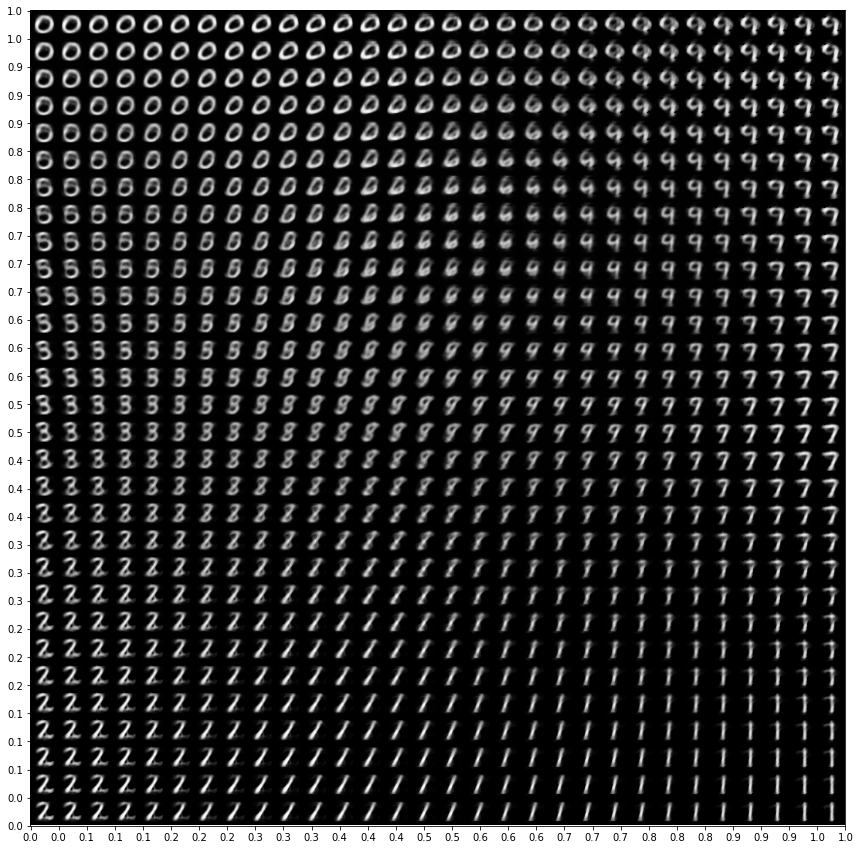

In [84]:
# HIPER-PARAMETROS A FIJAR
n = 30        # número de imágenes (digits del NMIST) a representar.
x_min = 0    # valor mínimo de la variable x del `latent space`.
x_max = 1     # valor mínimo de la variable x del `latent space`.
y_min = 0    # valor mínimo de la variable x del `latent space`.
y_max = 1     # valor mínimo de la variable x del `latent space`.


# Display a 2D manifold of the digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Rangos de evaluación del latent space
grid_x = np.linspace(x_min, x_max, n)
grid_y = np.linspace(y_min, y_max, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = torch.tensor([float(xi), float(yi)])
        x_decoded = decoder(z_sample)
        digit = x_decoded.view(1, 28, 28).data
        figure[(i) * digit_size: (i+1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(figure, cmap="gray")
ax.set_xticks(np.linspace(0,figure.shape[0],n))
ax.set_yticks(np.linspace(0,figure.shape[0],n))
ax.set_xticklabels(np.round(grid_x, decimals=1))
ax.set_yticklabels(np.flip(np.round(grid_y, decimals=1)))
plt.show()


### Resumen

Se analizó el espacio latente al cual mapea el encoder simple preentrenado con *simple_autoencoder_TP.pt* (para cierto batch de test). Se observa que barriendo x entre (0, 20) e y entre (0, 37) se tendría que poder reconstruir todo el dataset MNIST. Los valores de x e y son congruentes con el rango de la imagen de la *RELU* (no-linealidad), es decir, de (0, inf).

Luego se cambió la no-linealidad del encoder por *tanh*, se entrenó el modelo y se guardó en *simple_autoencoder_TP_tanh.pt*. El rango de la imagen de *tanh* es (-1, 1), de nuevo se verifica en el espacio latente.

Por último, se cambió la no-linealidad del encoder por *sigmoid*, se entrenó el modelo y se guardó en *simple_autoencoder_TP_sigmoid.pt*. El rango de la imagen de la nueva no-linealidada (0, 1), concuerda con el espacio latente.